# Feature Engineering and Modelling

---

1. Import packages
2. Load data
3. Modelling

---

## 1. Import packages

In [2]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt

# Shows plots in jupyter notebook
%matplotlib inline

# Set plot style
sns.set(color_codes=True)

In [4]:
from sklearn.metrics import roc_curve, roc_auc_score

---
## 2. Load data

In [5]:
df = pd.read_csv('./data_for_predictions.csv')
df.drop(columns=["Unnamed: 0"], inplace=True)
df.head()

,id,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,...,months_modif_prod,months_renewal,channel_MISSING,channel_ewpakwlliwisiwduibdlfmalxowmwpci,channel_foosdfpfkusacimwkcsosbicdxkicaua,channel_lmkebamcaaclubfxadlmueccxoimlema,channel_usilxuppasemubllopkaafesmlibmsdf,origin_up_kamkkxfxxuwbdslkwifmmcsiusiuosws,origin_up_ldkssxwpmemidmecebumciepifcamkci,origin_up_lxidpiddsbxsbosboudacockeimpuepw
0,24011ae4ebbe3035111d65fa7c15bc57,0.000000,4.739944,0.000000,0.000000,0.0,0.444045,0.114481,0.098142,40.606701,...,2,6,0,0,1,0,0,0,0,1
1,d29c2c54acc38ff3c0614d0a653813dd,3.668479,0.000000,0.000000,2.280920,0.0,1.237292,0.145711,0.000000,44.311378,...,76,4,1,0,0,0,0,1,0,0
2,764c75f661154dac3a6c254cd082ea7d,2.736397,0.000000,0.000000,1.689841,0.0,1.599009,0.165794,0.087899,44.311378,...,68,8,0,0,1,0,0,1,0,0
3,bba03439a292a1e166f80264c16191cb,3.200029,0.000000,0.000000,2.382089,0.0,1.318689,0.146694,0.000000,44.311378,...,69,9,0,0,0,1,0,1,0,0
4,149d57cf92fc41cf94415803a877cb4b,3.646011,0.000000,2.721811,2.650065,0.0,2.122969,0.116900,0.100015,40.606701,...,71,9,1,0,0,0,0,1,0,0


---

## 3. Modelling

We now have a dataset containing features that we have engineered and we are ready to start training a predictive model. Remember, we only need to focus on training a `Random Forest` classifier.

In [6]:
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [7]:
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV

### Data sampling


In [8]:
# Make a copy of our data
train_df = df.copy()

# Separate target variable from independent variables
y = df['churn']
X = df.drop(columns=['id', 'churn'])
print(X.shape)
print(y.shape)

(14606, 61)
(14606,)


### Train test split

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(10954, 61)
(10954,)
(3652, 61)
(3652,)


### Model training


### Fine tuning

In [10]:
#Grid Search
param_grid = {'max_depth': [5, 10],
              'n_estimators': [50, 100, 500],
              'max_features': ['sqrt'],
              'min_samples_leaf': [2, 5],
              'min_samples_split': [2, 5]
              }

# Create a based model
random_forest = RandomForestClassifier(
    class_weight="balanced_subsample", random_state=1)
# Instantiate the grid search model
grid_search = GridSearchCV(estimator=random_forest, param_grid=param_grid,
                            cv=3, n_jobs=-1, verbose=1, scoring='roc_auc')  # search for best model using roc_auc
# # Fit the grid search to the data
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


GridSearchCV(cv=3,
             estimator=RandomForestClassifier(class_weight='balanced_subsample',
                                              random_state=1),
             n_jobs=-1,
             param_grid={'max_depth': [5, 10], 'max_features': ['sqrt'],
                         'min_samples_leaf': [2, 5],
                         'min_samples_split': [2, 5],
                         'n_estimators': [50, 100, 500]},
             scoring='roc_auc', verbose=1)

In [11]:
model = grid_search.best_estimator_

In [12]:
predictions_proba = model.predict_proba(X_train)
print(f'Train AUC:{roc_auc_score(y_train,predictions_proba[:, 1])}')

Train AUC:0.9415157830806083


### Evaluation

Now let's evaluate how well this trained model is able to predict the values of the test dataset.

In [13]:
predictions = model.predict(X_test)
tn, fp, fn, tp = metrics.confusion_matrix(y_test, predictions).ravel()

In [14]:
predictions_proba = model.predict_proba(X_test)

In [15]:
print(f"True positives: {tp}")
print(f"False positives: {fp}")
print(f"True negatives: {tn}")
print(f"False negatives: {fn}\n")

print(f"Accuracy: {metrics.accuracy_score(y_test, predictions)}")
print(f"Precision: {metrics.precision_score(y_test, predictions)}")
print(f"Recall: {metrics.recall_score(y_test, predictions)}")
print(f'AUC:{roc_auc_score(y_test,predictions_proba[:, 1])}')

True positives: 108
False positives: 376
True negatives: 2910
False negatives: 258

Accuracy: 0.8263964950711938
Precision: 0.2231404958677686
Recall: 0.29508196721311475
AUC:0.6532582341378725


### Feature Importances

In [16]:
feature_importances = pd.DataFrame({
    'features': X_train.columns,
    'importance': model.feature_importances_
}).sort_values(by='importance', ascending=True).reset_index()

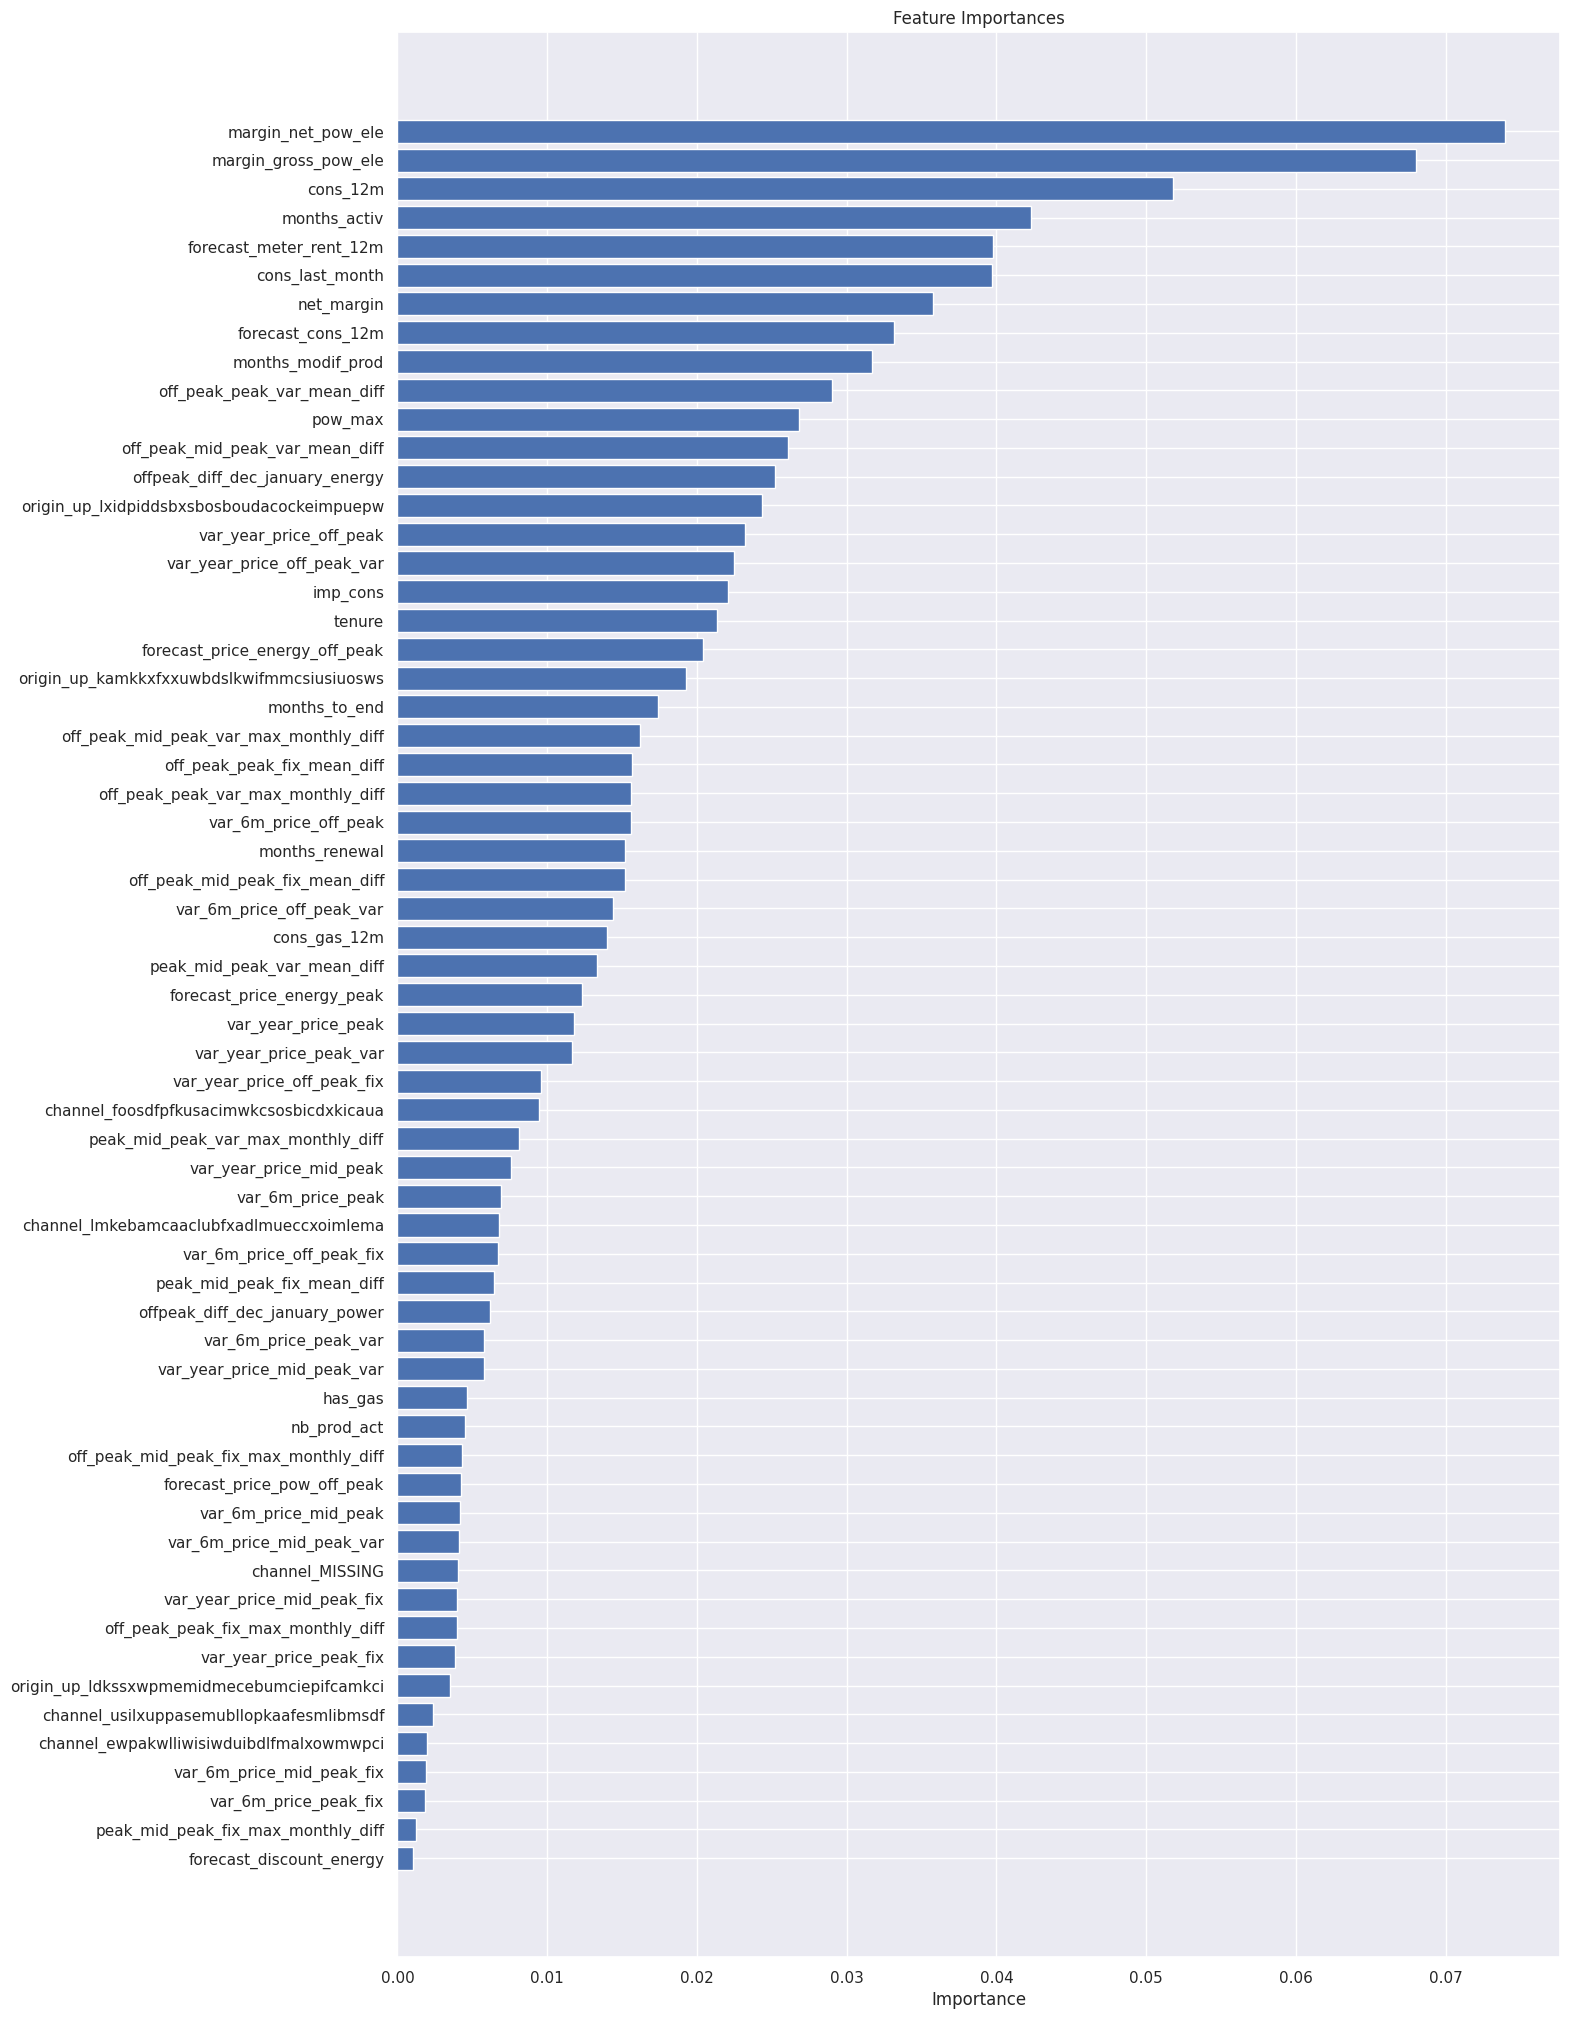

In [17]:
plt.figure(figsize=(15, 25))
plt.title('Feature Importances')
plt.barh(range(len(feature_importances)), feature_importances['importance'], color='b', align='center')
plt.yticks(range(len(feature_importances)), feature_importances['features'])
plt.xlabel('Importance')
plt.show()

### Explaining Random Forest Model With Shapely Values

In [67]:
pip install shap==0.44.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 533.5/533.5 kB 6.0 MB/s eta 0:00:00
  Attempting uninstall: shap
    Found existing installation: shap 0.45.0
    Uninstalling shap-0.45.0:
      Successfully uninstalled shap-0.45.0


In [18]:
import shap
# load JS visualization code to notebook
shap.initjs()

#sample observations if data size is greater than 1000
if X_train.shape[0]>1000:
    sample_tr=X_train.sample(n=1000)
else:
    sample_tr= X_train

explainer_shap = shap.TreeExplainer(model) #with hyperparameter best on train data,create an explainer object for a random forest model trained on the training data.
shap_values = explainer_shap.shap_values(X_test)# The explainer is then used to compute the SHAP values for the test set x.

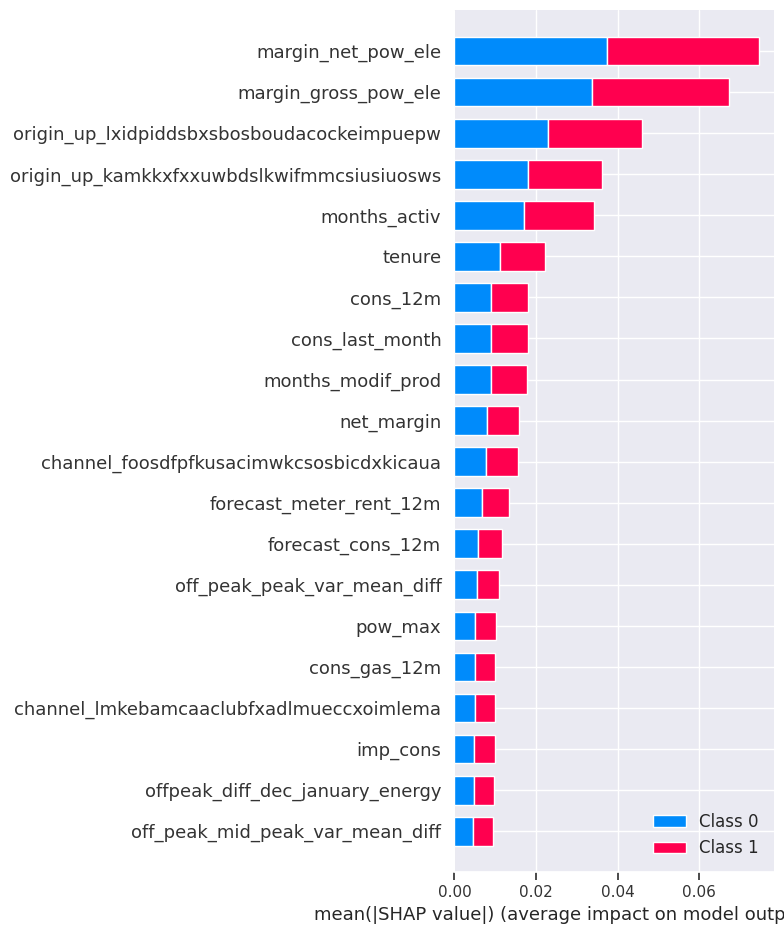

In [19]:
# Summarize the effects of features
shap.summary_plot(shap_values, X_test,plot_type='bar')

The summary plot is a graphical representation of the feature importance of each feature in the model. It is a useful tool for understanding how the model makes predictions and for identifying the most important features.

In our case, it shows feature importance per target class. It turns out the “margin_net_pow”, “margin_gross_pow”, and origin and active months play an important role in determining the churn.  

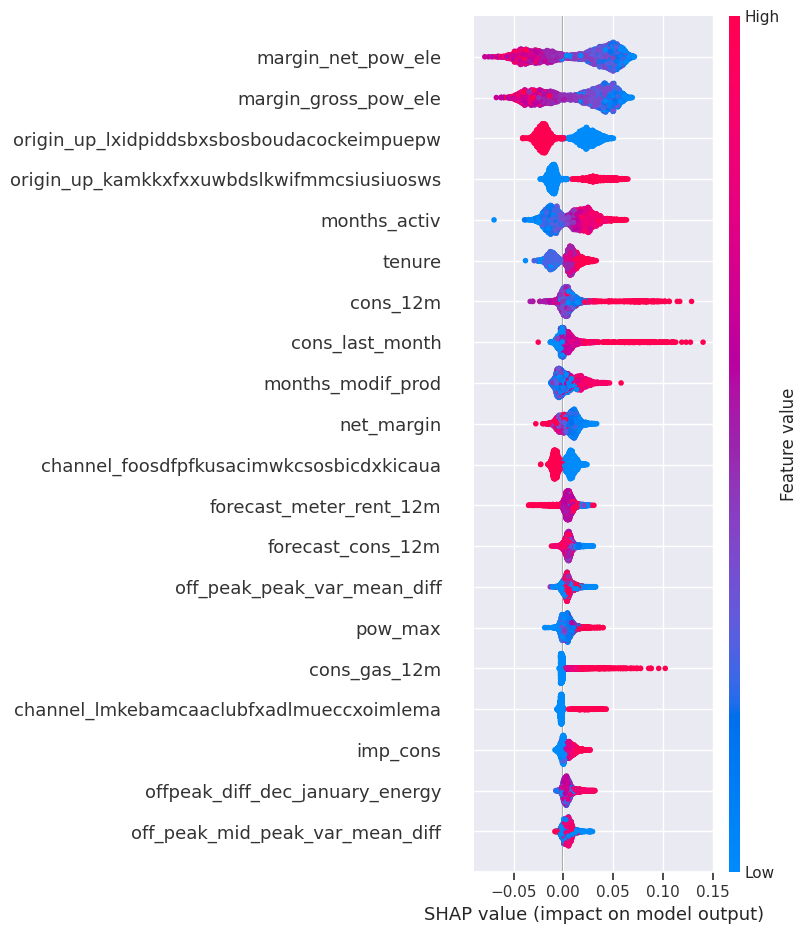

In [20]:
shap.summary_plot(shap_values[0], X_test)

We will now visualize the future importance of the class “0”. We can clearly see that, margin_net_pow, margin_gross_pow have negative effects for predicting non churn customers.